# PlexAI
Diese Software erlaubt es, ein KI-Modell zu trainieren, dass die Beziehungen zwischen den von uns gemessenen Daten erlernt und so fehlende Daten ausfüllen könnte.

Sie können in der links stehen Dateiübersicht die Daten als csv Datei hochladen. Achten Sie darauf, dass die Datei "data.csv" heißt.
Sie können die Daten von unserer [Webseite](https://plexplore.org) herunterladen

## Module importieren und Konstanten setzen

In [35]:
import torch
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
BATCH_SIZE = 50
LR = 1e-4
MIN_MASKS = 3
MAX_MASKS = 15
N_MASKS = 60
SPLIT_LENGTH = 5

NUM_HEADS = 4
LATEND_DIM = 64
NUM_LAYERS = 2
DROPOUT = 0.1
POS_EMBEDDING = True

## Datenset erstellen

### Datenset vorbereiten

In [4]:
#Lädt die Flugdaten

fall_start = 940_000
fall_end = 1_020_000

data = pd.read_csv("data.csv", sep=";", header=0)
data = data[(data["Time"] >= fall_start) & (data["Time"] <= fall_end)]

data

Time  Temperature  Air Pressure  Humidity        VOC  Latitude  \
934    940366     21.66027      1019.862  25.05288  12.549684  53.12687   
935    941366     21.65930      1019.862  25.05810  12.546205  53.12687   
936    942366     21.65715      1019.864  25.07383  12.549913  53.12687   
937    943366     21.65070      1018.391  25.06808  12.552145  53.12687   
938    944366     21.62551      1013.857  25.05571  12.555355  53.12687   
...       ...          ...           ...       ...        ...       ...   
1009  1015368     13.74074      1019.465  34.91521  12.889076  53.12721   
1010  1016368     13.80637      1019.594  35.25259  12.900824  53.12836   
1011  1017368     13.86516      1019.697  35.53381  12.923187  53.12836   
1012  1018368     13.91867      1019.755  35.80951  12.923684  53.12838   
1013  1019368     13.96984      1019.808  36.05724  12.937092  53.12838   

      Longitude  Altitude      Dust    Oxygen  Nitrogen  
934    9.353645      32.7   82.5000  20.97735     72482  
935    9.353645      32.7  350.6250  20.97325     73604  
936    9.353645      32.7  835.3125  20.99936     72386  
937    9.353645      32.7  525.9375  21.00345     72162  
938    9.353645      32.7  886.8750  20.96416     73508  
...         ...       ...       ...       ...       ...  
1009   9.357238     349.9  237.1875  24.06829     83494  
1010   9.359418     349.9    0.0000  23.96768     84134  
1011   9.359418     349.9    0.0000  23.86477     82790  
1012   9.359473       7.4    0.0000  23.74573     83910  
1013   9.359473       7.4    0.0000  23.62464     82886  

[80 rows x 11 columns]

In [5]:
time = data["Time"]

data = data.drop(columns=["Time", "Dust", "Nitrogen", "VOC"])
data

Temperature  Air Pressure  Humidity  Latitude  Longitude  Altitude  \
934      21.66027      1019.862  25.05288  53.12687   9.353645      32.7   
935      21.65930      1019.862  25.05810  53.12687   9.353645      32.7   
936      21.65715      1019.864  25.07383  53.12687   9.353645      32.7   
937      21.65070      1018.391  25.06808  53.12687   9.353645      32.7   
938      21.62551      1013.857  25.05571  53.12687   9.353645      32.7   
...           ...           ...       ...       ...        ...       ...   
1009     13.74074      1019.465  34.91521  53.12721   9.357238     349.9   
1010     13.80637      1019.594  35.25259  53.12836   9.359418     349.9   
1011     13.86516      1019.697  35.53381  53.12836   9.359418     349.9   
1012     13.91867      1019.755  35.80951  53.12838   9.359473       7.4   
1013     13.96984      1019.808  36.05724  53.12838   9.359473       7.4   

        Oxygen  
934   20.97735  
935   20.97325  
936   20.99936  
937   21.00345  
938   20.96416  
...        ...  
1009  24.06829  
1010  23.96768  
1011  23.86477  
1012  23.74573  
1013  23.62464  

[80 rows x 7 columns]

Splitte das Datenset zu klein normalisierte Stücke, die jeweils als eine Eingabe gelten

In [7]:

n = len(data) // SPLIT_LENGTH
pt_data = torch.tensor(data.to_numpy()).to(device)
A_min = pt_data.min(dim=0, keepdim=True).values
A_max = pt_data.max(dim=0, keepdim=True).values

#Normalisieren
pt_data = pt_data / A_max

splits = []

for i in range(n):
  splits.append(pt_data[i*SPLIT_LENGTH: min((i+1)*SPLIT_LENGTH, len(pt_data))])


In [8]:
splits[0].shape

torch.Size([5, 7])

### Masken erstellen

In [9]:
def generate_unique_masks(a, b, n, x, y):
    if x > y or x < 0 or y > a * b:
        raise ValueError("Ungültige Werte für x und y")

    masks = set()
    max_attempts = 1000  # Begrenzung der Versuche, um Endlosschleifen zu vermeiden
    attempts = 0

    while len(masks) < n and attempts < max_attempts:
        mask_size = np.random.randint(x, y + 1)
        mask = np.zeros((a, b), dtype=int)
        indices = np.random.choice(a * b, mask_size, replace=False)
        mask[np.unravel_index(indices, (a, b))] = 1

        mask_tuple = tuple(mask.flatten())  # Konvertiere in hashbares Format

        if mask_tuple not in masks:
            masks.add(mask_tuple)
        else:
            attempts += 1

        if attempts >= max_attempts:
            print("Maximale Anzahl an Versuchen erreicht. Beende Generierung.")
            break

    return [np.array(mask).reshape(a, b) for mask in masks]

In [10]:
masks = generate_unique_masks(splits[0].shape[0], splits[0].shape[1], N_MASKS, MIN_MASKS, MAX_MASKS)
masks[0].shape

(5, 7)

### Masken anwenden und Batches generieren

In [16]:
def apply_masks_to_dataframe(df_array, masks, batch_size):
    tensor_list = []


    for i in range(0, len(masks), batch_size):
        batch_masks = masks[i:i+batch_size]
        batch_tensors = []

        for mask in batch_masks:
            masked_array = df_array.clone()
            masked_array[mask == 1] = 0
            batch_tensors.append(torch.tensor(masked_array, dtype=torch.float32))

        tensor_list.append(torch.stack(batch_tensors))

    return tensor_list

In [17]:
final_data= []

for i, split in enumerate(splits[:int(len(splits)*0.8)]):
  masked_d = apply_masks_to_dataframe(split, masks, BATCH_SIZE)
  final_data += [{"label":splits[i].unsqueeze(0).repeat(d.shape[0], 1, 1).to(device), "label_index":i, "data": d.to(device)} for d in masked_d]
random.shuffle(final_data)

<ipython-input-16-a9edd32d4b5f>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_tensors.append(torch.tensor(masked_array, dtype=torch.float32))


In [18]:
final_data[0]["data"][0]

tensor([[0.7111, 0.0000, 0.5012, 0.0000, 0.9993, 0.0000, 0.8221],
        [0.7029, 0.0000, 0.0000, 1.0000, 0.9993, 0.0851, 0.8335],
        [0.6949, 0.0000, 0.5278, 1.0000, 0.9993, 0.0851, 0.0000],
        [0.6875, 0.9566, 0.5411, 1.0000, 0.9993, 0.0851, 0.8523],
        [0.0000, 0.9581, 0.5546, 1.0000, 0.9993, 0.0000, 0.0000]],
       device='cuda:0')

In [ ]:
final_data[0]["label"][0]

tensor([[1.0000, 1.0000, 0.6948, 1.0000, 0.9994, 0.0840, 0.8130],
        [1.0000, 1.0000, 0.6950, 1.0000, 0.9994, 0.0840, 0.8128],
        [0.9999, 1.0000, 0.6954, 1.0000, 0.9994, 0.0840, 0.8143],
        [0.9996, 0.9986, 0.6952, 1.0000, 0.9994, 0.0840, 0.8145],
        [0.9984, 0.9941, 0.6949, 1.0000, 0.9994, 0.0840, 0.8123]],
       device='cuda:0', dtype=torch.float64)

Train und Test Splits einteilen

In [19]:
train = final_data[:int(len(final_data)*0.8)]
test = final_data[int(len(final_data)*0.8):]

## Modelarchitektur

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, num_heads, num_layers, dropout=0.1):
        """
        Transformer Autoencoder Modell
        :param input_dim: Anzahl der Sensormesswerte (Spalten der Matrix)
        :param latent_dim: Dimension des Latent Space
        :param num_heads: Anzahl der Attention Heads im Transformer
        :param num_layers: Anzahl der Transformer Layer
        :param dropout: Dropout-Rate für das Modell
        """
        super(TransformerAutoencoder, self).__init__()

        # Encoder
        self.encoder_embedding = nn.Linear(input_dim, latent_dim)  # Einbettung der Eingangsdaten
        if POS_EMBEDDING: self.encoder_positional_encoding = nn.Parameter(torch.rand(1, SPLIT_LENGTH, latent_dim))  # Positional Encoding

        self.encoder_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=latent_dim, nhead=num_heads, dropout=dropout),
            num_layers=num_layers
        )

        # Decoder
        self.decoder_transformer = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=latent_dim, nhead=num_heads, dropout=dropout),
            num_layers=num_layers
        )

        self.decoder_output = nn.Linear(latent_dim, input_dim)  # Rekonstruktion der Eingabedaten

    def forward(self, x):
        """
        Forward-Pass durch das Modell.
        :param x: Eingabedaten mit Form [batch_size, seq_len, input_dim]
        :return: Rekonstruierte Daten
        """
        # Encoder
        x = self.encoder_embedding(x)  # Embedding der Eingangsdaten
        if POS_EMBEDDING: x = x + self.encoder_positional_encoding[:, :x.size(1), :]  # Hinzufügen der Positional Encoding

        # Transponieren, um Transformer-Eingabeform zu erhalten
        x = x.permute(1, 0, 2)  # [seq_len, batch_size, latent_dim]
        encoded = self.encoder_transformer(x)

        # Decoder (Rekonstruktion der Einagbe)
        decoded = self.decoder_transformer(encoded, encoded)  # Decoder mit Encoder-Ausgabe
        decoded = decoded.permute(1, 0, 2)  # Zurück transponieren für Ausgabe

        # Ausgabe
        output = self.decoder_output(decoded)
        return output


In [22]:
model = TransformerAutoencoder(train[0]["data"].shape[-1], LATEND_DIM, NUM_HEADS, NUM_LAYERS, DROPOUT)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## Model trainieren

In [ ]:
EPOCHS = 100

In [ ]:
train[0]["data"].shape

torch.Size([50, 5, 7])

In [27]:
optimizer = optim.Adam(model.parameters(), lr=LR)
train_losses = []
test_losses = []

model.to(device)

# Verlustfunktion (Mean Squared Error)
def calculate_loss(output, target):
    return F.mse_loss(output, target)

# Training Schleife
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for batch_idx, data in enumerate(train):
        masked_data = data['data'].float()
        original_data = data['label'].float()

        # Stelle sicher, dass die maskierten Daten korrekt geformt sind
        masked_data = masked_data.view(masked_data.size(0), -1, masked_data.size(2))
        original_data = original_data.view(original_data.size(0), -1, original_data.size(2))


        #Nutze die Daten zum Training
        output = model(masked_data)

        loss = calculate_loss(output, original_data)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Gebe den Verlust aus
    avg_epoch_loss = epoch_loss / len(train)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_epoch_loss:.4f}')
    train_losses.append(avg_epoch_loss)

    # Teste das Modell alle 10 Epochen
    if (epoch + 1) % 10 == 0:
        model.eval()
        test_loss = 0

        with torch.no_grad():
            for data in test:
                masked_data = data['data'].float()
                original_data = data['label'].float()


                masked_data = masked_data.view(masked_data.size(0), -1, masked_data.size(2))
                original_data = original_data.view(original_data.size(0), -1, original_data.size(2))


                output = model(masked_data)


                loss = calculate_loss(output, original_data)
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test)
        print(f'Test Loss after Epoch {epoch+1}: {avg_test_loss:.4f}')
        test_losses.append(avg_test_loss)

# Modell nach dem Training speichern
torch.save(model.state_dict(), 'transformer_autoencoder.pth')

Epoch [1/50], Loss: 0.1558
Epoch [2/50], Loss: 0.0414
Epoch [3/50], Loss: 0.0359
Epoch [4/50], Loss: 0.0339
Epoch [5/50], Loss: 0.0298
Epoch [6/50], Loss: 0.0266
Epoch [7/50], Loss: 0.0235
Epoch [8/50], Loss: 0.0219
Epoch [9/50], Loss: 0.0205
Epoch [10/50], Loss: 0.0189
Test Loss after Epoch 10: 0.0067
Epoch [11/50], Loss: 0.0182
Epoch [12/50], Loss: 0.0184
Epoch [13/50], Loss: 0.0169
Epoch [14/50], Loss: 0.0165
Epoch [15/50], Loss: 0.0166
Epoch [16/50], Loss: 0.0152
Epoch [17/50], Loss: 0.0152
Epoch [18/50], Loss: 0.0150
Epoch [19/50], Loss: 0.0145
Epoch [20/50], Loss: 0.0147
Test Loss after Epoch 20: 0.0066
Epoch [21/50], Loss: 0.0141
Epoch [22/50], Loss: 0.0139
Epoch [23/50], Loss: 0.0131
Epoch [24/50], Loss: 0.0129
Epoch [25/50], Loss: 0.0133
Epoch [26/50], Loss: 0.0127
Epoch [27/50], Loss: 0.0132
Epoch [28/50], Loss: 0.0124
Epoch [29/50], Loss: 0.0137
Epoch [30/50], Loss: 0.0142
Test Loss after Epoch 30: 0.0070
Epoch [31/50], Loss: 0.0140
Epoch [32/50], Loss: 0.0135
Epoch [33/50],

## Auswertung

### Gebe Graphen des Trainings und der Evaluation aus

Text(0, 0.5, 'Fehler')

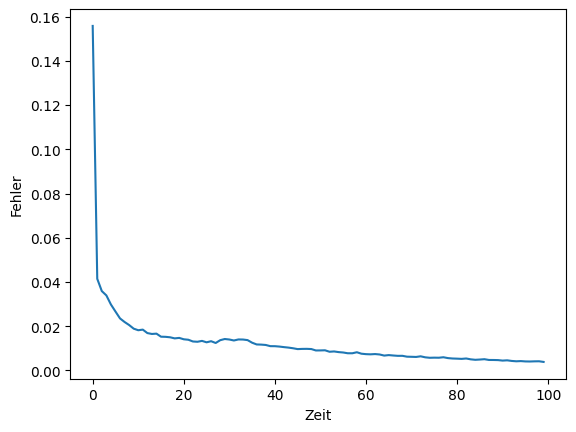

In [29]:
plt.plot(range(len(train_losses)), train_losses)
plt.xlabel('Zeit')
plt.ylabel('Fehler')

Die Evaluation nutzt Maskierungsbeispiele, die nicht fürs Training verwendet wurden

Text(0, 0.5, 'Fehler')

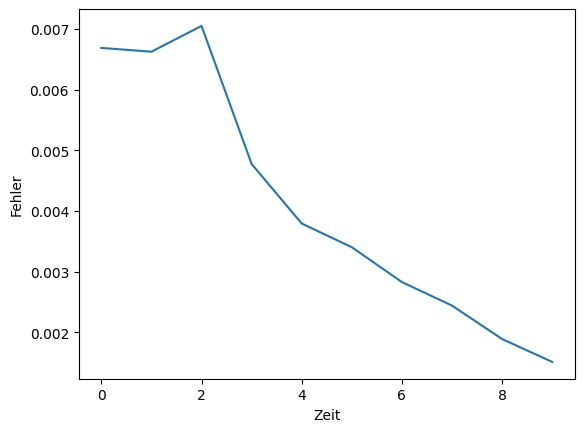

In [30]:
plt.plot(range(len(test_losses)), test_losses)
plt.xlabel('Zeit')
plt.ylabel('Fehler')

### Gebe die Accuracy der Demaskierungsvorschläge aus (Wie gut kann das Modell fehlende Werte vorhersagen?)

In [33]:
threshold = 0.1

result_accuracy = 0

for d in test:
  output = model.forward(d["data"])
  mask = d["data"] == 0

  masked_output = output[mask]
  masked_labels = d["label"][mask]

  diff = torch.abs(masked_output - masked_labels)
  correct = (diff <= threshold).sum().item()

  total = mask.sum().item()
  accuracy = (correct / total) * 100 if total > 0 else 0.0
  result_accuracy += accuracy/5

In [34]:
result_accuracy

96.48715350843011